### Load libraries

In [126]:
from dotenv import load_dotenv
import os

from langchain.chat_models import ChatOpenAI
from langchain.tools import Tool
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate

import boto3
import pandas as pd

### Load environment variables
I created .env file where I stored different api keys (AWS and openai).

In [127]:
load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("AWS_REGION")

# Set the OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

### LLM
I will use chatgpt 3.5 turbo as llm for this tutorial, You can use another llm models.\
[List of llm models that you can use with langchain](https://python.langchain.com/docs/integrations/chat/#all-chat-models)

In [128]:
# Create the OpenAI chat model
chat = ChatOpenAI(
    model="gpt-4o-mini",  # You can use also "gpt-3.5-turbo" / gpt-4 if you want
    temperature=0.2
)

### Data
I will use an S3 cluster data for this tutorial, I will upload data and then push it to postgres database.

##### Read S3

In [129]:
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"]=AWS_SECRET_ACCESS_KEY
# os.environ["AWS_REGION"]= AWS_REGION

# Initialize S3 client
s3_client = boto3.client("s3")

# Function to list files in an S3 bucket
def list_s3_objects(bucket_name):
    response = s3_client.list_objects_v2(Bucket=bucket_name)
    if "Contents" in response:
        return [obj["Key"] for obj in response["Contents"]]
    return "No files found in the bucket."

# Function to read a file from S3
def read_s3_object(bucket_name, file_key):
    response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    # content = response["Body"].read().decode("utf-8")
    content = pd.read_csv(response["Body"])
    return content


In [130]:
list_s3_objects("earthquakedb")

['data_etl.csv']

In [131]:
df = read_s3_object("earthquakedb", "data_etl.csv")
df.head(10)

,Unnamed: 0,Year,Local_Time,UTC_Time,Magnitude,Location,Depth,Latitude,Longitude,Event_type,Assessment,Agency
0,0,2025,Feb 11 01:04:40,Feb 11 00:04:40,1.1,Zinal VS,6.7,46.15,7.71,NaN,automatic,SED
1,1,2025,Feb 10 22:50:01,Feb 10 21:50:01,0.7,Leukerbad VS,6.1,46.37,7.57,earthquake,manual,SED
2,2,2025,Feb 10 18:03:43,Feb 10 17:03:43,0.5,Chamonix F,5.9,45.90,7.01,earthquake,manual,SED
3,3,2025,Feb 10 14:35:00,Feb 10 13:35:00,0.7,Sanetschpass VS,3.1,46.32,7.34,earthquake,manual,SED
4,4,2025,Feb 10 07:59:28,Feb 10 06:59:28,1.6,Bourg-Saint-Pierre VS,5.4,45.93,7.04,earthquake,manual,SED
5,5,2025,Feb 10 07:29:21,Feb 10 06:29:21,1.1,Aosta I,10.3,45.80,7.44,earthquake,manual,SED
6,6,2025,Feb 10 02:12:57,Feb 10 01:12:57,0.6,Aosta I,8.9,45.80,7.43,earthquake,manual,SED
7,7,2025,Feb 10 02:07:45,Feb 10 01:07:45,1.9,Aosta I,9.2,45.80,7.44,earthquake,manual,SED
8,8,2025,Feb 10 02:07:20,Feb 10 01:07:20,1.9,Aosta I,8.0,45.80,7.44,earthquake,manual,SED
9,9,2025,Feb 09 20:54:11,Feb 09 19:54:11,0.2,Bourg-Saint-Pierre VS,4.4,45.93,7.04,earthquake,manual,SED


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8746 entries, 0 to 8745
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8746 non-null   int64  
 1   Year        8746 non-null   int64  
 2   Local_Time  8746 non-null   object 
 3   UTC_Time    8746 non-null   object 
 4   Magnitude   8746 non-null   float64
 5   Location    8746 non-null   object 
 6   Depth       8746 non-null   float64
 7   Latitude    8746 non-null   float64
 8   Longitude   8746 non-null   float64
 9   Event_type  8745 non-null   object 
 10  Assessment  8746 non-null   object 
 11  Agency      8746 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 820.1+ KB


#### Assign Canton name

In [133]:
import geopandas as gpd
from shapely.geometry import Point
from langchain.tools import Tool, StructuredTool
from langchain.agents import initialize_agent, AgentType
from pydantic import BaseModel

# Load the Swiss cantons Shapefile
# Ensure you provide the correct path to your Shapefile
shapefile_path = "shp/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp"

regions_gdf = gpd.read_file(shapefile_path)
if regions_gdf.crs is None:
        regions_gdf.set_crs("EPSG:4326", inplace=True)  # Assuming WGS84

# Convert points list to a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(df["Longitude"], df["Latitude"])]
points_gdf = gpd.GeoDataFrame(
        df,geometry=geometry,  # Create Point geometry
        crs="EPSG:4326"  # Set coordinate reference system
)
if regions_gdf.crs != points_gdf.crs:
        regions_gdf = regions_gdf.to_crs(points_gdf.crs)
joined = gpd.sjoin(points_gdf, regions_gdf, how="left", predicate="within")
joined = joined[joined["OBJEKTART"]=="Kanton"]
data = joined[["Unnamed: 0", "Year", "Local_Time", "Magnitude", "Location", "Latitude", "Longitude", "NAME"]]
data.head(10)

,Unnamed: 0,Year,Local_Time,Magnitude,Location,Latitude,Longitude,NAME
0,0,2025,Feb 11 01:04:40,1.1,Zinal VS,46.15,7.71,Valais
1,1,2025,Feb 10 22:50:01,0.7,Leukerbad VS,46.37,7.57,Valais
3,3,2025,Feb 10 14:35:00,0.7,Sanetschpass VS,46.32,7.34,Valais
15,15,2025,Feb 08 00:05:51,0.6,Bourg-Saint-Pierre VS,45.93,7.05,Valais
17,17,2025,Feb 08 20:58:09,2.0,Bourg-Saint-Pierre VS,45.93,7.05,Valais
22,22,2025,Feb 08 08:53:07,2.3,Bourg-Saint-Pierre VS,45.93,7.05,Valais
24,24,2025,Feb 08 05:51:33,1.3,Bourg-Saint-Pierre VS,45.94,7.05,Valais
25,25,2025,Feb 08 05:18:55,0.6,Bourg-Saint-Pierre VS,45.93,7.05,Valais
26,26,2025,Feb 08 03:55:23,1.8,Bourg-Saint-Pierre VS,45.94,7.05,Valais
31,31,2025,Feb 08 01:46:32,0.8,Bourg-Saint-Pierre VS,45.93,7.05,Valais


##### Load S3 data into postgres table

#### Create database

In [134]:
import pandas as pd
from sqlalchemy import create_engine
import psycopg2

# PostgreSQL credentials
db_host = "localhost"
db_user = "postgres"
db_pass = "postgres"
db_port = "5432"  # Default PostgreSQL port
db_name = "llm_sql"

In [135]:
# Create database
try:
    conn = psycopg2.connect(
        dbname="postgres", user=db_user, password=db_pass, host=db_host, port=db_port
    )
    conn.autocommit = True
    cursor = conn.cursor()
    cursor.execute(f"CREATE DATABASE {db_name};")
    cursor.close()
    conn.close()
    print(f"Database '{db_name}' created successfully.")
except psycopg2.errors.DuplicateDatabase:
    print(f"Database '{db_name}' already exists.")
except Exception as e:
    print(f"Error creating database: {e}")


Database 'llm_sql' already exists.


##### Create table and push data

In [136]:
from sqlalchemy import create_engine, Column, Integer, String, Float, MetaData, Table, DateTime
from sqlalchemy.exc import SQLAlchemyError

# Create a PostgreSQL engine
engine = create_engine(f'postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}')

In [138]:
from sqlalchemy.exc import NoSuchTableError

metadata_obj = MetaData()
table_name = "earthquakes"

try:
    table = Table(table_name, metadata_obj, autoload_with=engine)
    table.drop(engine)
    print(f"Table '{table_name}' deleted successfully.")
except NoSuchTableError:
    print(f"Table '{table_name}' does not exist.")

Table 'earthquakes' does not exist.


In [139]:

# Sample DataFrame
# data = read_s3_object("earthquakedb", "data_etl.csv")
data = data.rename(columns={"Unnamed: 0":   "Index",
                            "Location":     "location",
                            "Magnitude":    "magnitude",
                            "Latitude":     "latitude",
                            "Longitude":    "longitude",
                            "NAME":         "canton"})
data = data[["Index", "Year", "Local_Time", "magnitude", "location", "latitude", "longitude", "canton"]]
data = data[(data["magnitude"]>=2) & (data["Year"]>=2018)]

data["local_Time"] = pd.to_datetime(data["Year"].astype(str) + " " + data["Local_Time"],
                                    format="%Y %b %d %H:%M:%S")
data.drop(columns=["Year", "Local_Time"], inplace=True)

# Define your table schema
earthquake_table = Table(
    "earthquakes", metadata_obj,
    Column("Index", Integer, primary_key=True, autoincrement=True),
    Column("local_time", DateTime),
    Column("magnitude", Float),
    Column("location", String(255)),
    Column("latitude", Float),
    Column("longitude", Float),
    Column("canton", String(255))
)

# Create the table if it does not exist
try:
    metadata_obj.create_all(engine)
    print("Table created (if not exists).")
except SQLAlchemyError as e:
    print(f"Error creating table: {e}")

# Push the DataFrame into PostgreSQL (replace table if it exists)
data.to_sql('earthquakes', engine, if_exists='replace', index=False)

print("Data successfully pushed to PostgreSQL!")

Table created (if not exists).
Data successfully pushed to PostgreSQL!


##### Test
To test, I am retrieving first 10 records.

In [140]:
query = "SELECT * FROM earthquakes LIMIT 10;"
pd.read_sql(query, engine)

,Index,magnitude,location,latitude,longitude,canton,local_Time
0,17,2.0,Bourg-Saint-Pierre VS,45.93,7.05,Valais,2025-02-08 20:58:09
1,22,2.3,Bourg-Saint-Pierre VS,45.93,7.05,Valais,2025-02-08 08:53:07
2,171,2.3,Lausanne VD,46.51,6.74,Vaud,2025-01-15 05:11:13
3,243,2.1,Samnaun GR,46.90,10.31,Graubünden,2025-01-06 15:23:19
4,245,2.3,Cevio TI,46.34,8.55,Ticino,2025-01-06 09:56:49
5,249,2.2,Kreuzlingen TG,47.63,9.21,Thurgau,2025-01-05 16:54:55
6,254,2.0,Savognin GR,46.59,9.57,Graubünden,2025-01-03 15:29:42
7,270,2.2,Boncourt JU,47.48,7.01,Jura,2024-12-31 07:33:28
8,350,2.4,Weinfelden TG,47.60,9.08,Thurgau,2024-12-20 16:17:11
9,396,2.3,Sanetschpass VS,46.33,7.39,Valais,2024-12-13 08:24:30


### SQL Agent

In [141]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain.agents import create_sql_agent, AgentExecutor
from langchain.agents.agent_types import AgentType

db = SQLDatabase.from_uri(f'postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}')

# Create a SQLDatabase Toolkit (this contains the necessary tools)
toolkit = SQLDatabaseToolkit(db=db, llm=chat)


In [142]:
tools = toolkit.get_tools()
print([tool.name for tool in tools])

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']


In [144]:
# Define prompt
# prompt = ChatPromptTemplate.from_template("{input}")
prompt = ChatPromptTemplate.from_template(
    "{input}\n\nPrevious Actions:\n{agent_scratchpad}"
)

# Create LangChain SQL agent
sql_agent = create_openai_tools_agent(
    llm=chat,
    tools=tools,
    prompt=prompt,
)

# Create agent executor
agent_executor = AgentExecutor(agent=sql_agent,
                               tools=tools,
                               verbose=False)

### Simple questions

- 10 first records

In [145]:
response1 = agent_executor.invoke({"input": "Display the first 10 records from the earthquakes table."})
print(response1['output'])

Here are the first 10 records from the earthquakes table:

1. **ID:** 17, **Magnitude:** 2.0, **Location:** Bourg-Saint-Pierre VS, **Latitude:** 45.93, **Longitude:** 7.05, **Region:** Valais, **Date:** 2025-02-08 20:58:09
2. **ID:** 22, **Magnitude:** 2.3, **Location:** Bourg-Saint-Pierre VS, **Latitude:** 45.93, **Longitude:** 7.05, **Region:** Valais, **Date:** 2025-02-08 08:53:07
3. **ID:** 171, **Magnitude:** 2.3, **Location:** Lausanne VD, **Latitude:** 46.51, **Longitude:** 6.74, **Region:** Vaud, **Date:** 2025-01-15 05:11:13
4. **ID:** 243, **Magnitude:** 2.1, **Location:** Samnaun GR, **Latitude:** 46.90, **Longitude:** 10.31, **Region:** Graubünden, **Date:** 2025-01-06 15:23:19
5. **ID:** 245, **Magnitude:** 2.3, **Location:** Cevio TI, **Latitude:** 46.34, **Longitude:** 8.55, **Region:** Ticino, **Date:** 2025-01-06 09:56:49
6. **ID:** 249, **Magnitude:** 2.2, **Location:** Kreuzlingen TG, **Latitude:** 47.63, **Longitude:** 9.21, **Region:** Thurgau, **Date:** 2025-01-05

- strongest earthquake recorded

In [146]:
response2 = agent_executor.invoke({"input": "Retrieve the record of the earthquake of the most magnitude"})
print(response2['output'])

The record of the earthquake with the highest magnitude is as follows:

- **Magnitude**: 4.4
- **Location**: Pragelpass GL/SZ
- **Latitude**: 47.05
- **Longitude**: 8.86
- **Canton**: Schwyz
- **Local Time**: 2024-06-04 02:34:32


- Oldest record

In [147]:
response4 = agent_executor.invoke({"input": "when was the oldest record in earthquake table."})
print(response4['output'])

The oldest record in the earthquakes table is from July 2, 2019, at 01:13:57.


- Region with most earthquakes

In [148]:
response5 = agent_executor.invoke({"input": "In which swiss Location occurs the most earthquakes."})
print(response5['output'])

The Swiss location that experiences the most earthquakes is Elm GL, with a total of 42 recorded earthquakes.


In [149]:
response6 = agent_executor.invoke({"input": "In which swiss canton occurs the most earthquakes"})
print(response6['output'])

To determine which Swiss canton experiences the most earthquakes, we would typically analyze seismic data specific to Switzerland. However, I currently do not have access to real-time seismic data or databases that contain such information.

Generally, the cantons located in the Alps, such as Valais (Wallis), Bern, and Graubünden, tend to experience more seismic activity due to their geological characteristics. If you need specific data or statistics, I recommend checking with the Swiss Seismological Service or relevant geological surveys for the most accurate and up-to-date information.


In [150]:
response7 = agent_executor.invoke({"input": "Give me top 5 swiss cantons with the most earthquakes"})
print(response7['output'])

The top 5 Swiss cantons with the most earthquakes are:

1. Valais - 109 earthquakes
2. Graubünden - 44 earthquakes
3. Glarus - 43 earthquakes
4. Jura - 32 earthquakes
5. Bern - 16 earthquakes


Add new tool

In [151]:
import matplotlib
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
repl_tool.name = "python_interpreter"

In [152]:
tools = toolkit.get_tools()
tools.append(repl_tool)
print([tool.name for tool in tools])

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker', 'python_interpreter']


In [122]:
import matplotlib.pyplot as plt
import geopandas as gpd
from langchain_experimental.utilities import PythonREPL
from langchain.tools import Tool

def plot_geodata():
    """
    Executes Python code to generate a geoplot.
    The function assumes a predefined GeoDataFrame `gdf` is available.
    """
    try:
        # Load a sample dataset if gdf is not provided
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 6))
        world.plot(ax=ax, color='lightgrey', edgecolor='black')

        # Save the plot
        plot_path = "geoplot.png"
        plt.savefig(plot_path)
        plt.close()

        return f"GeoPlot saved as {plot_path}"

    except Exception as e:
        return f"Error in plotting: {str(e)}"

# Define the tool
repl_tool = Tool(
    name="geo_plotter",
    description="Generates a geoplot. Assumes geospatial data is available and plots it using GeoPandas & Matplotlib.",
    func=plot_geodata
)

# Add the tool to the SQL agent tools
tools = toolkit.get_tools()
tools.append(repl_tool)

# Verify tools
print([tool.name for tool in tools])


['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker', 'geo_plotter']


In [153]:
# Define prompt
# prompt = ChatPromptTemplate.from_template("{input}")
prompt = ChatPromptTemplate.from_template(
    "{input}\n\nPrevious Actions:\n{agent_scratchpad}"
)

# Create LangChain SQL agent
sql_agent = create_openai_tools_agent(
    llm=chat,
    tools=tools,
    prompt=prompt,
)

# Create agent executor
agent_executor = AgentExecutor(agent=sql_agent,
                               tools=tools,
                               verbose=False)

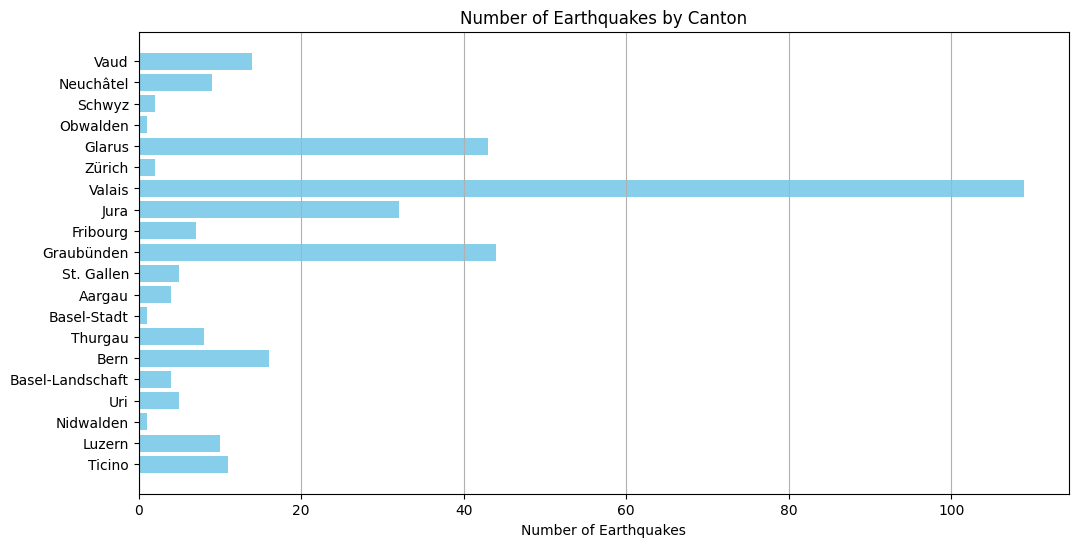

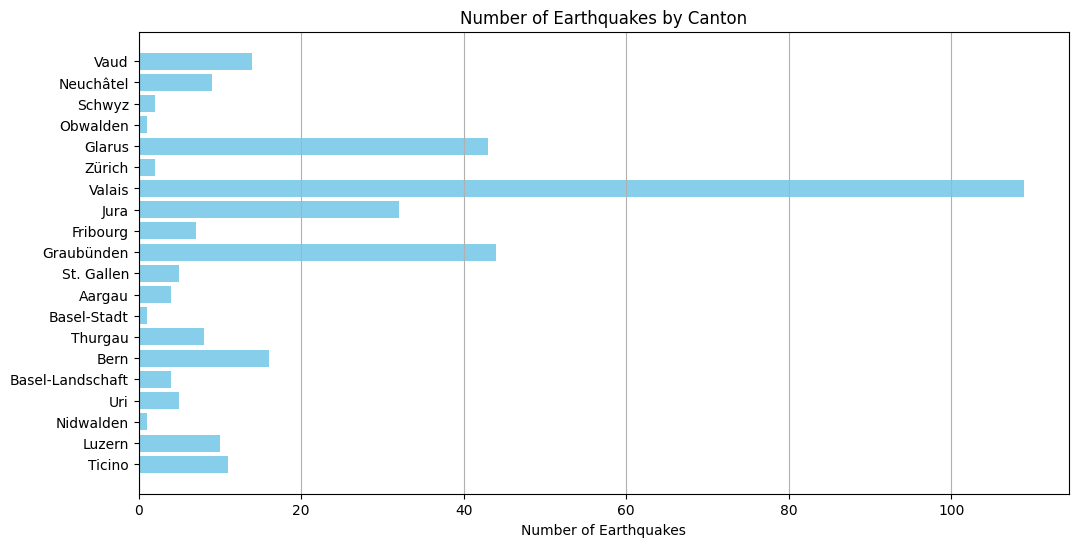

{'input': 'Count number of earthquakes for each canton and plot it', 'output': 'The number of earthquakes for each canton has been counted and plotted successfully. Here are the results:\n\n- **Ticino**: 11\n- **Luzern**: 10\n- **Nidwalden**: 1\n- **Uri**: 5\n- **Basel-Landschaft**: 4\n- **Bern**: 16\n- **Thurgau**: 8\n- **Basel-Stadt**: 1\n- **Aargau**: 4\n- **St. Gallen**: 5\n- **Graubünden**: 44\n- **Fribourg**: 7\n- **Jura**: 32\n- **Valais**: 109\n- **Zürich**: 2\n- **Glarus**: 43\n- **Obwalden**: 1\n- **Schwyz**: 2\n- **Neuchâtel**: 9\n- **Vaud**: 14\n\nThe plot visualizing the number of earthquakes by canton is displayed below:\n\n![Number of Earthquakes by Canton](attachment://earthquake_counts_by_canton.png)'}


In [154]:
response8 = agent_executor.invoke({"input": "Count number of earthquakes for each canton and plot it"})
print(response8)